### Use this notebook to calculate the FLH-parameters that will be plugged into the technical potential calculation to account for the fact that we have hourly data, and not instantaneous

In [21]:
wind_RE = 'offshore' #'onshore' / 'offshore'

In [100]:
import netCDF4 as nc
import xarray as xr
import pandas as pd
import os
import numpy as np
import dask
import pathlib
import math

from scipy.stats import weibull_min
import scipy.signal
from scipy.interpolate import UnivariateSpline

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

xr.set_options(keep_attrs = True)

import proplot as pplt
pplt.rc['style'] = 'seaborn-paper'

import set_ID
wind_path = set_ID.wind_path
plots_path = f'{wind_path}/onoffshore/plots/'

In [23]:
# sample windspeed in bins of 1m/s
mean_ws = np.arange(0.5, 50.5)

/data/scratch/globc/baur/RE_analysis/wind/weibull_dist_example.png


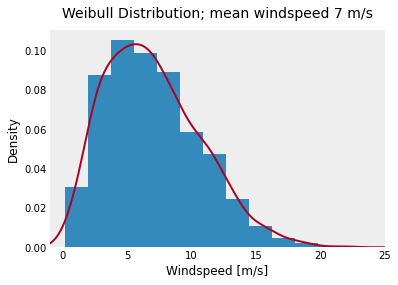

In [24]:
### Plot example

k = 2 #shape param
mu = 0 #loc param
ws = 7
c = ws*(0.568 + 0.433/2)**-(1/2)
wei_dist = weibull_min.rvs(k, mu, c, size=1000)  #random variates

wei_ex = pd.Series(wei_dist) 


fig, ax = plt.subplots(figsize = (6,4))

plt.style.use("bmh")

wei_ex.plot(kind = "hist", density = True, bins = 12) 
wei_ex.plot(kind = "kde")

ax.set_xlabel("Windspeed [m/s]")
ax.set_xlim(-1, 25)

ax.set_title("Weibull Distribution; mean windspeed 7 m/s", fontsize=14, pad=12)
ax.grid(False)
# Remove ticks and spines
ax.tick_params(left = False, bottom = False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)


# Calculate two-parameter Weibull-distribution (1000 samples) for each of the 50 windspeed bins

In [25]:
ws_bin_vals = []
k = 2 #shape param -> width of distribution  should be (std_dev / mean_ws)**-1.086 (see Shu & Jessen 2021)
mu = 0 #loc param

# get weibull dist for all windspeed bins
for ws in mean_ws:
    # calcualte scale param from mean windspeed
    c = ws*(0.568 + 0.433/2)**-(1/2) #abscissa (Lysen, 1983)
    # weibull dist
    wei_vals = weibull_min.rvs(k, mu, c, size=1000)
    ws_bin_vals.append(wei_vals)
    
# ws_bin_vals is a list with 50 elements, each element is an array of the weibull distribution

In [26]:
# probability that the turbine will be in operation (Shu & Jessen, 2021)
cut_in = 3 #m/s
cut_out = 25 #m/s
np.exp(-(cut_in/40)**2) - np.exp(-(cut_out/40)**2)

0.317756944529352

# Power calculation for each bin 

In [27]:
power_out = dict()
for power_curve_setting in ['', '_nocutout']:
    if wind_RE == 'onshore':  # Vestas V162-6.2 
        cut_in = 3 #m/s
        cut_out = 25 #m/s
        rated_ws = 10 #m/s   
        rated_power = 6200000  # W 
        phi = 1.2 #kg/m3 air density
        rotor_diameter = 162 #m

    elif wind_RE == 'offshore':  # Vestas V236-15 
        cut_in = 3 #m/s
        cut_out = 30 #m/s
        rated_ws = 12.5 #m/s     
        rated_power = 15000000 # W
        phi = 1.2 #kg/m3 air density
        rotor_diameter = 236 #m
    else:
        print('choose a wind type')
    #turbine curve and FLH calc
    rotor_area = math.pi * (rotor_diameter/2)**2
    power_coeff = 0.397 #(Dai et al. 2016)


    def wind_power(WS_bin):
        output_list = []
        output_list_power = []

        if power_curve_setting == '':
            for ws in WS_bin:
                ## ws lower than cutin or higher than cutout -> set to 0
                if ws < cut_in or ws > cut_out:
                    output_list.append(0)
                    output_list_power.append(0)

                ## ws between cutin and rated -> follows Parametric wind turbine power curve (Saint-Drenan et al. 2020)
                elif ws > cut_in and ws < rated_ws:
                    #power 
                    PWT_II = (0.5 * phi * rotor_area * ws**3 * power_coeff)
                    # Full load hour
                    FLH_II = (PWT_II*8760)/rated_power
                    output_list.append(FLH_II)
                    output_list_power.append(PWT_II)
                    # above rated ws but still below cut out -> rated power
                elif ws > rated_ws and ws < cut_out:
                    PWT_III = rated_power
                    FLH_III = (PWT_III*8760)/rated_power
                    output_list.append(FLH_III)
                    output_list_power.append(PWT_III)
            return output_list_power

        elif power_curve_setting == '_nocutout':
            for ws in WS_bin:
                ## ws lower than cutin -> set to 0
                if ws < cut_in:
                    output_list.append(0)
                    output_list_power.append(0)
                ## ws between cutin and rated -> follows Parametric wind turbine power curve (Saint-Drenan et al. 2020)
                elif ws > cut_in and ws < rated_ws:
                    #power 
                    PWT_II = (0.5 * phi * rotor_area * ws**3 * power_coeff)
                    # Full load hour
                    FLH_II = (PWT_II*8760)/rated_power
                    output_list.append(FLH_II)
                    output_list_power.append(PWT_II)
                    # above rated ws but still below cut out -> rated power
                elif ws > rated_ws:
                    PWT_III = rated_power
                    FLH_III = (PWT_III*8760)/rated_power
                    output_list.append(FLH_III)
                    output_list_power.append(PWT_III)
            return output_list_power
        else:
            print('this turbine setting does not yet exist')

    FLH_=[]
    li=[]

    for i in range(0,50):
        FLH_.append(wind_power(ws_bin_vals[i]))
    
    for i in range(0,50):
        # *1e-6 turns it from W to MW
        li.append(np.mean(FLH_[i])*1e-6)
    power_out[power_curve_setting] = li
    

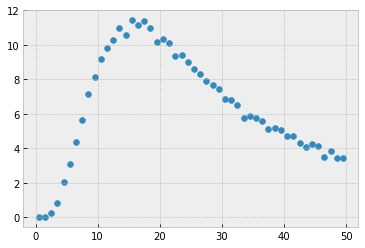

In [28]:
plt.scatter(mean_ws, power_out[''])

## Difference between normal and nocutout

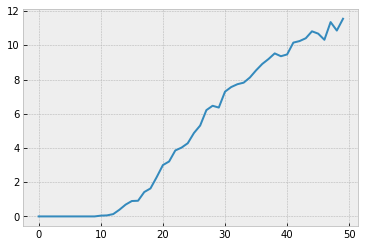

In [139]:
plt.plot(np.array(power_out['_nocutout']) - np.array(power_out['']))

In [140]:
y = np.array(power_out['_nocutout']) - np.array(power_out[''])
x = mean_ws

## Curve fitting difference normal and no-cut-out

In [141]:
from scipy.optimize import curve_fit
# defining the function for the difference between "normal" and "no-cut-out"
def func(x, a, b, c):
    return a*(1-np.exp(-x**4/b))*(1-np.exp(-x**2/c))

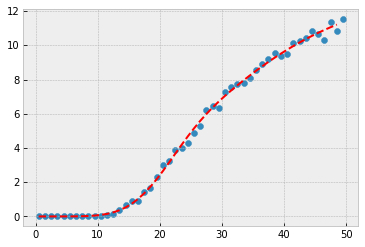

In [142]:
# curve fit
popt, _ = curve_fit(func, x, y, p0=[0,100, 100])

# summarize the parameter values
a, b, c = popt

fig, ax = plt.subplots(figsize = (6,4))

ax.scatter(x, y)
# define a sequence of inputs between the smallest and largest known inputs
x_line = np.arange(min(x), max(x), 1)
# calculate the output for the range
y_line = func(x_line, a, b, c)
# line plot for the mapping function
ax.plot(x_line, y_line, '--', color='red')

In [148]:
for a, i in zip(popt, ['a', 'b', 'c', 'd']):
    print(i +': ' + '{0:.10f}'.format(a))

a: 12.9792322438
b: 153831.9959263891
c: 1181.9686894277


## Curve fitting normal

In [17]:
from scipy.optimize import curve_fit
# defining the function
def func(x, a, b, c, d):
    return a*(1-np.exp(-x**2/b))*(1-np.exp(-x**2/c))*(np.exp(-x/d))

In [29]:
offshore = power_out['']

/tmp/ipykernel_367716/1986589203.py:4: RuntimeWarning: overflow encountered in exp
  return a*(1-np.exp(-x**2/b))*(1-np.exp(-x**2/c))*(np.exp(-x/d))


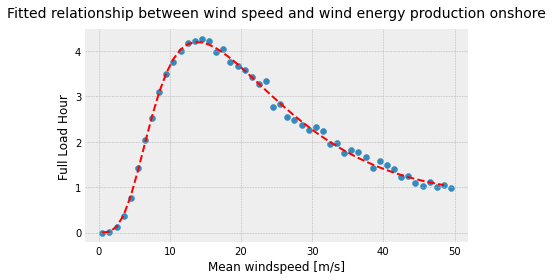

In [19]:
# Curve fitting and plotting

x, y = mean_ws, power_out['']
# curve fit
if power_curve_setting == '_nocutout':
    popt, _ = curve_fit(func, x, y, p0=[1e8,260,1000,1000])
elif power_curve_setting == '':
    popt, _ = curve_fit(func, x, y, p0=[1e8,60,50,6])
# summarize the parameter values
a, b, c,d  = popt

fig, ax = plt.subplots(figsize = (6,4))

ax.scatter(x, y)
# define a sequence of inputs between the smallest and largest known inputs
x_line = np.arange(min(x), max(x), 1)
# calculate the output for the range
y_line = func(x_line, a, b, c, d)
# line plot for the mapping function
ax.plot(x_line, y_line, '--', color='red')

ax.set_xlabel("Mean windspeed [m/s]")
#ax.set_ylabel("Full Load Hour")

#ax.set_ylim(-400, 8000)

ax.set_title("Fitted relationship between wind speed and wind energy production "+wind_RE, fontsize=14, pad=12)
#ax.grid(False)
# Remove ticks and spines
ax.tick_params(left = False, bottom = False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)
plt.tight_layout()


In [32]:
x = mean_ws

In [44]:
a_ = 9.0112876712 
b = 88.1921278770 
c = 28.7390245618 
d = 21.6199534039 
on_curve = a_*(1-np.exp(-x**2/b))*(1-np.exp(-x**2/c))*(np.exp(-x/d))

a_ = 24.5600807182
b = 129.6477860229
c = 24.9388367925
d = 24.8750720898
off_curve = a_*(1-np.exp(-x**2/b))*(1-np.exp(-x**2/c))*(np.exp(-x/d))

a_nco = 5.2762550001
b_nco = 75499.3188179671
c_nco = 787.4449790994
on_nocut = a_nco*(1-np.exp(-x**4/b_nco))*(1-np.exp(-x**2/c_nco))

a_nco = 12.9792322438
b_nco= 153831.9959263891
c_nco = 1181.9686894277
off_nocut = a_nco*(1-np.exp(-x**4/b_nco))*(1-np.exp(-x**2/c_nco))

on_nocut_curve = on_curve + on_nocut
off_nocut_curve = off_curve + off_nocut

/data/scratch/globc/baur/RE_analysis/wind//onoffshore/plots/paper_plots/fitted_PWH_windspeed.png


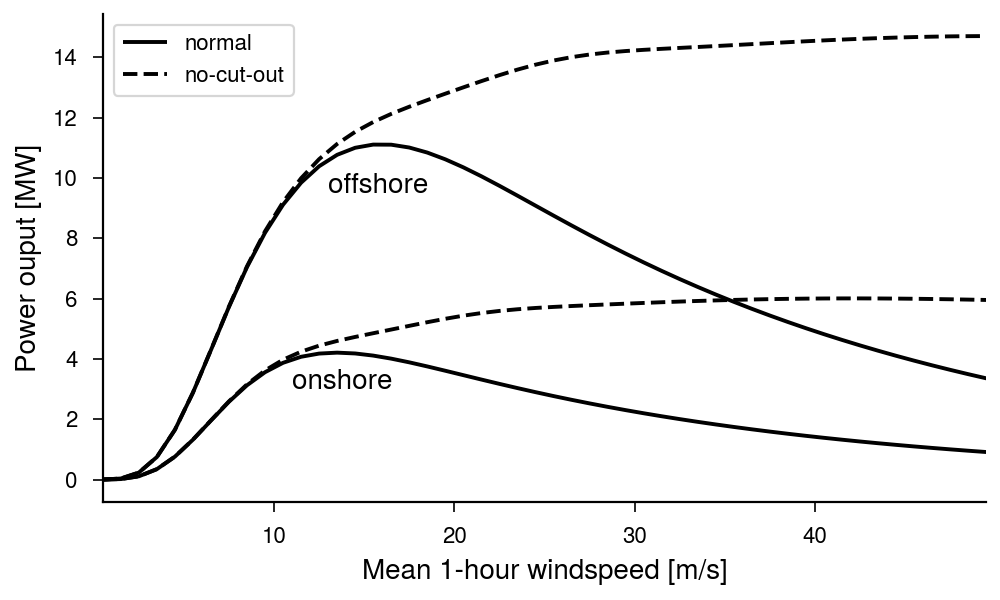

In [103]:
fig, ax = pplt.subplots(figsize = (5,3))

ax.plot(x, on_curve, '-', color='black')
ax.plot(x, off_curve, '-', color='black')
ax.plot(x, on_nocut_curve, '--', color='black')
ax.plot(x, off_nocut_curve, '--', color='black')

ax.set_xlabel("Mean 1-hour windspeed [m/s]", size=10)
ax.set_ylabel("Power ouput [MW]", size=10)

#ax.set_ylim(-400, 8000)

#ax.set_title("Fitted relationship between wind speed and wind energy production", fontsize=14, pad=12)
ax.grid(False)
# Remove ticks and spines
#ax.tick_params(left = False, bottom = False)
ax.spines[['right', 'top']].set_visible(False)

plt.text(11, 3, "onshore", size=10)
plt.text(13, 9.5, "offshore", size=10)
# legend
handles, labels = plt.gca().get_legend_handles_labels()
line1 = Line2D([0], [0], label='normal', linestyle = '-',color='black')
line2 = Line2D([0], [0], label='no-cut-out', linestyle = '--',color='black')
handles.extend([line1, line2])
plt.legend(handles=handles, ncols=1)

